# Contractility

As explained earlier, we let the cells contract – and make the matrix follow the motion. This is mathematically defined by continuity of displacement, as well as continuity of stress in the normal direction (of the membrane surface).

We'll here go through the two options for incoporating contractility – active stress and active strain. As you'll see towards the end, this choice matters a lot both for strain and stress patterns. Determining which is more correct is, however, not so trivial – and remains an open research question.

We will use the code from the main repository [emimechanicalmodel](https://github.com/aashildte/emimechanicalmodel/), which is based on FEniCS. We can import all libraries we need in this demo as follows, and read in the mesh and subdomains, as usual:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import fenics as f
import emimechanicalmodel as emi_m

f.set_log_level(30)        # less verbatim output from the Newton solver compared to default

mesh_file = "tile_connected_10p0.h5"
mesh, volumes = emi_m.load_mesh(mesh_file)

Mesh and subdomains loaded successfully.
Number of nodes: 965, number of elements: 4071


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Incoporating active contraction

When we solve the mechanical problem, we want to find a displacement field $\mathbf{u}$ which gives us an _equilibrium of stresses_. We are, essentially, solving for a three-dimensional version of Newton's third law, expressed by Piola-Kirchhoff stress tensor $\mathbf{P}$:

$$\nabla \cdot \mathbf{P} = 0$$

We can here express $\mathbf{P}$ as an equilibrium between active and passive forces.

There are two ways we can incoporate that the cells are contracting. We can use an _active stress_ approach (which works in an additive manner) or and _active strain_ approach (working in a multiplicative manner). Both are reasonable choices, but the active stress approach might be easier to connect to physiological relevant quantities, while the active strain approach has certain numerical advantages.

### Active stress

Using an active stress approach, we can decompose $\mathbf{P}$ into a passive and an active term:

$$ P = \frac{\partial \Psi_{passive} (F)}{\partial F} + \frac{\partial \Psi_{active} (F)}{\partial F}$$

The active part is, in this code, given in as a driver of the model. In more advanced models it can be dependent on a number of other relevant variables, e.g. calcium dynamics.

The separation of active contribution in the different subdomains is pretty straight forward: We assume that the cells contract – with a non-zero contribution – and that the matrix does not contract. Mathematically we can say that the active tension is zero in the extracellular subdomain:

$$
\Psi_{active} = \begin{cases} \frac{T_{active}(t)}{2} || \mathbf{F} \mathbf{f}_0 ||^2 \qquad \qquad \ x \in \Omega_i \\ 0 \qquad \quad \qquad \qquad \qquad x \in \Omega_e \end{cases}
$$

Here, $T_{active}$ is a function which we take to be dependent on time, predefined, but in general can take e.g. calcium distributions, sarcomere dynamics, etc. into account.

### Active strain

Using an active strain approach, we do a multiplicative decomposition. We define a function $\gamma (t)$, which like $\Psi_{active}$ is defined differently in each subdomain:

$$
\gamma = \begin{cases} \gamma_i (t) \qquad \qquad \ \ \ \; x \in \Omega_i \\ 0 \qquad \qquad \qquad x \in \Omega_e \end{cases}
$$

$\gamma$ has a theoretical upper bound of 1, but usually around 

then we define a tensor $\mathbf{F}_{a}$ as follows:

$$
\mathbf{F}_a =
\begin{bmatrix}
1 - \gamma & 0 & 0 \\
0 & (1 - \gamma)^{-1/2} & 0 \\
0 & 0 & (1 - \gamma)^{-1/2}
\end{bmatrix}
$$

We next define $\mathbf{F}$ as the product between two matrices,

$$
\mathbf{F} = \mathbf{F}_p \mathbf{F}_a.
$$

implying that

$$
\mathbf{F}_p = \mathbf{F} \mathbf{F}_a^{-1}
$$

and, through the chain rule, we obtain that

$$
\mathbf{P} = \mathrm{det} (\mathbf{F}_a) \frac{\partial \psi (\mathbf{F}_p)}{\partial \mathbf{F}_p} \mathbf{F}_a^{-\mathrm{T}}
$$

Note that the only difference from more traditional tissue-level mechanics is that we define $\gamma$ discretely; the mathematics otherwise hold in general (see e.g. Rossi; citation needed).

## Active transient

We will use the force calculated from the Rice model to calculate $T_{active} (t)$ (using the active stress approach) or $\gamma_i (t)$ (using the active strain approach). Note that this is _weakly_ coupled; we are not giving the local strain (which can be translated to the change in the sarcomere length) back to the Rice model. Physiologically this would have made most sense, but this is a non-trivial task – that no-one so far has been able to do for the EMI model!

We have, for convenience, precalculated the force transient which we will read in for now. Later on, we'll play with some of the parameters to get different active tension transients based on changes in calcium and myofilament dynamics. We can read in, and plot, the pre-calculated values as follows:

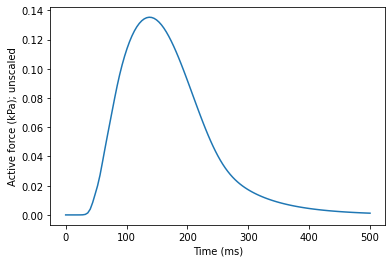

In [2]:
time = np.linspace(0, 500, 125)       # 500 ms with 125 steps

active_force_normalized = emi_m.compute_active_component(time)

plt.plot(time, active_force_normalized)
plt.xlabel("Time (ms)")
plt.ylabel("Active force (kPa); unscaled")
plt.show()

This is meant to resemble half of a single beat (up t0 500 ms, out of 1000). We here, for the sake of saving some time in running the simulations, cut off the transient before it goes back to zero, meaning we'll end with a state which is not completely at rest. If you run the simulation all the way to 1000 ms, however, you'll get back to the zero baseline case.

Note that this is a normalized beat, which needs to be scaled up to resemble contraction in a physiologically relevant range. Doubling the magnitude gives reasonable strain values (about 20 \% shortening of the cell) for the active strain approach:

In [3]:
active_precomputed_active_strain = 2*active_force_normalized

... and multiplying with a factor of 500 gives reasonable strain values for the active stress approach:

In [4]:
active_precomputed_active_stress = 500*active_force_normalized

The values "2" and "500" are chosen fairly arbitarily, simply adjusted to get something that looks reasonable. These might, depepnding on your application, might be useful to experiment with.

# Running the forward model

Let's use the active values from above. We can update the active contraction in a for loop, like this, and solve the system in every iteration. As before, we will be tracking intracellular strain and stress values for comparison:

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

active_models = ["active_strain", "active_stress"]
active_values_precomputed = [active_precomputed_active_strain, active_precomputed_active_stress]

for active_model, active_values in zip(active_models, active_values_precomputed):

    emimodel = emi_m.EMIModel(
            mesh,
            volumes,
            experiment="contraction",
            active_model=active_model,
        )
    
    fiber_dir_strain_i = np.zeros_like(active_values)
    fiber_dir_stress_i = np.zeros_like(active_values) 
    subdomain_id = 1         # intracellular subdomain

    # then run the simulation
    for step, a_str in enumerate(active_values):
        
        emimodel.update_active_fn(a_str)
        emimodel.solve()
    
        fiber_dir_strain_i[step] = \
            emimodel.evaluate_subdomain_strain_fibre_dir(subdomain_id)
        fiber_dir_stress_i[step] = \
            emimodel.evaluate_subdomain_stress_fibre_dir(subdomain_id)

    axes[0].plot(time, fiber_dir_strain_i)
    axes[1].plot(time, fiber_dir_stress_i)

    
axes[0].legend(["Active strain", "Active stress"])
    
axes[0].set_xlabel("Time (ms)")
axes[1].set_xlabel("Time (ms)")
axes[0].set_ylabel("Strain (-)")
axes[1].set_ylabel("Stress (kPa)")

axes[0].set_title(r"Fiber direction strain, over $\Omega_i$")
axes[1].set_title(r"Fiber direction stress, over $\Omega_i$")

plt.show()

length=102.0, width=20.0, height=24.0
length=102.0, width=20.0, height=24.0
